## Credit
Fork from [Single Cells Perturbations -- 1 | Kaggle](https://www.kaggle.com/code/amanmukati/single-cells-perturbations-1)

## Data Loading

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import time

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
#from pyvis.network import Network

# Machine learning libraries
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

# Advanced analysis libraries
import umap
import shap
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.spatial.distance import squareform

# CatBoost
import catboost
from catboost import CatBoostRegressor, Pool
from sklearn.multioutput import MultiOutputRegressor

In [2]:
# Loading additional data required for mapping
BASE = '/kaggle/input/open-problems-single-cell-perturbations/'

In [3]:
# Displaying the first few rows of the ID map for inspection
train_data = pd.read_parquet(f'{BASE}de_train.parquet')

----
# EDA

In [4]:
# Display general information about the dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Columns: 18216 entries, cell_type to ZZEF1
dtypes: bool(1), float64(18211), object(4)
memory usage: 85.3+ MB


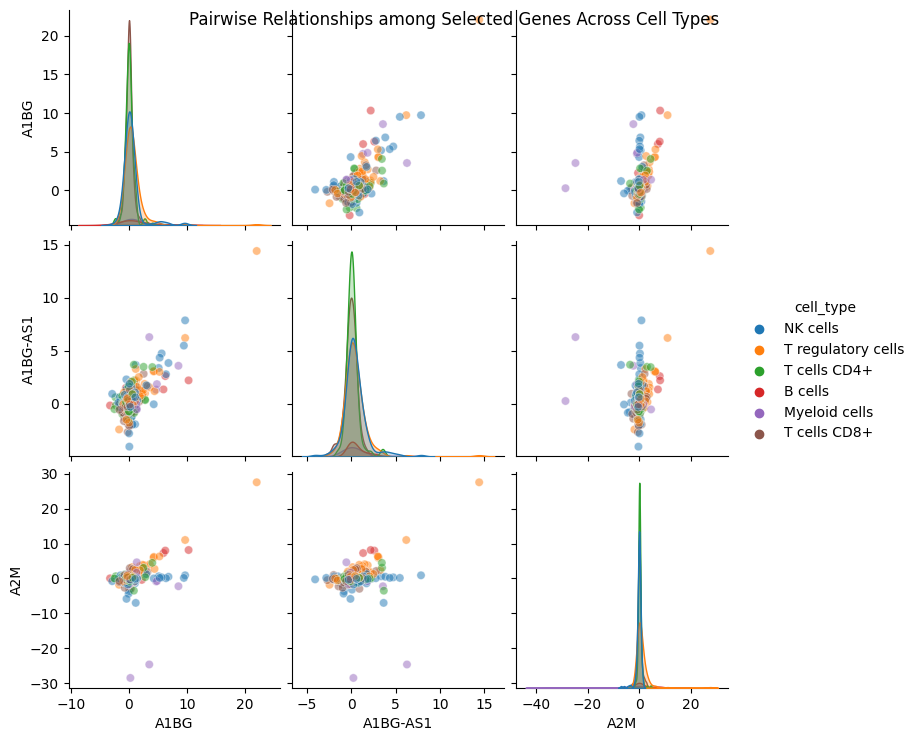

In [5]:
sns.pairplot(train_data.sample(613)[['A1BG', 'A1BG-AS1', 'A2M', 'cell_type']], hue='cell_type', plot_kws={'alpha':0.5})
plt.suptitle('Pairwise Relationships among Selected Genes Across Cell Types')
plt.show()

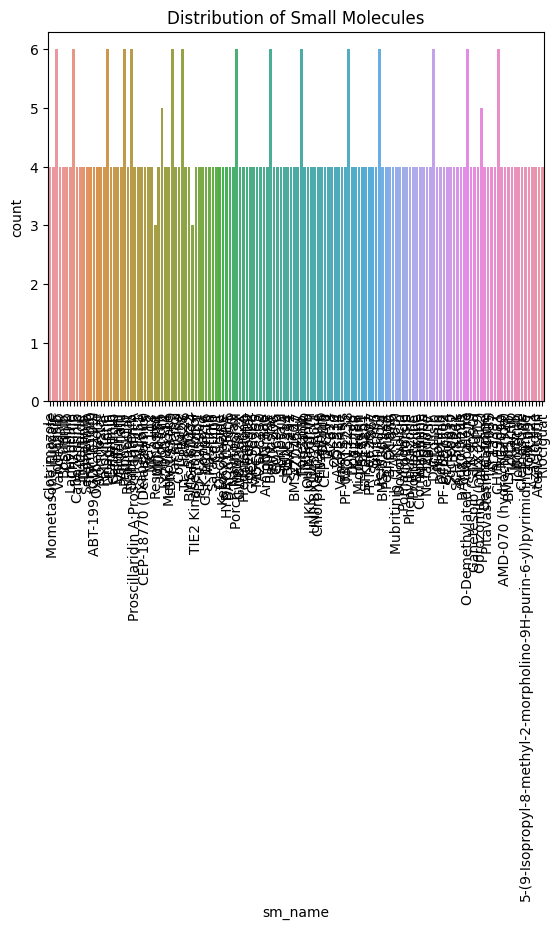

In [6]:
sns.countplot(x='sm_name', data=train_data)
plt.title('Distribution of Small Molecules')
plt.xticks(rotation=90)
plt.show()

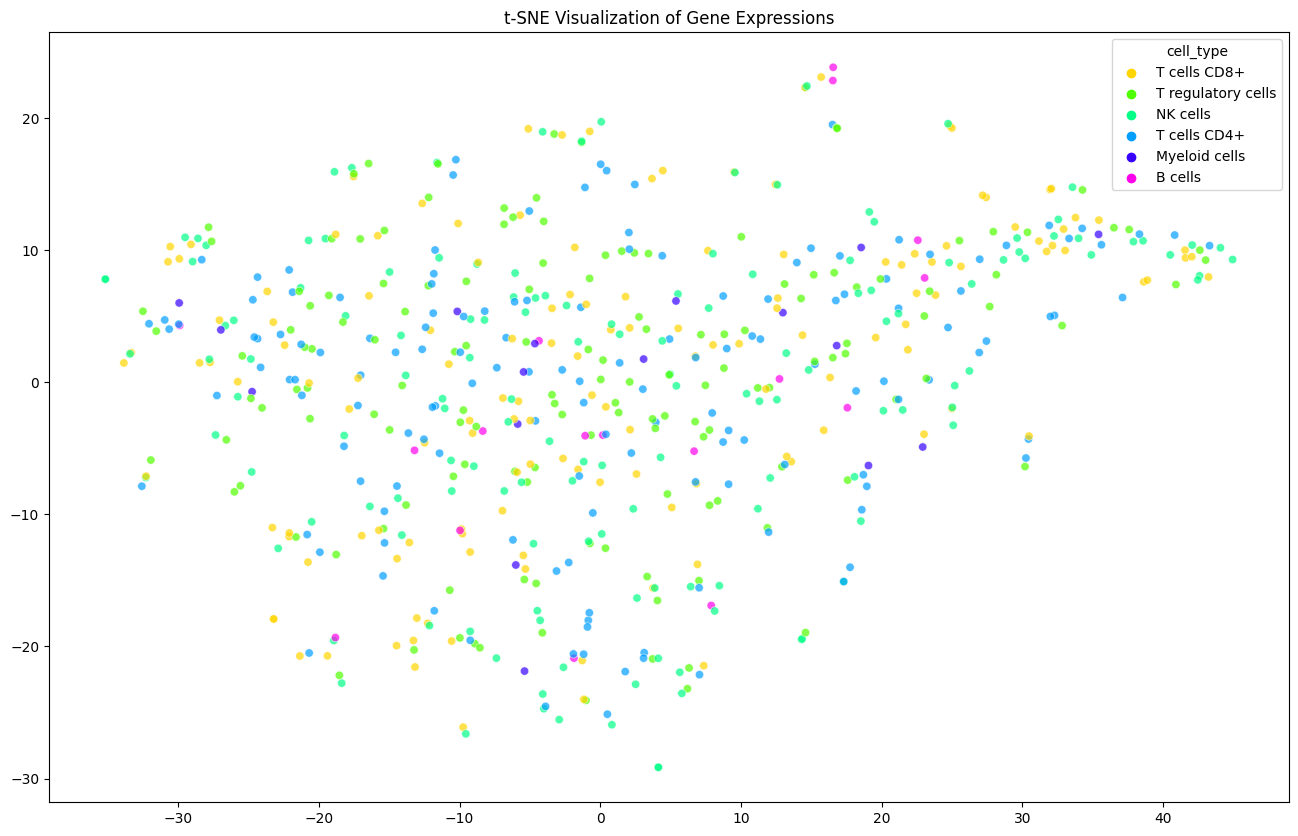

In [7]:
# Adjust the sample size to the number of rows in your DataFrame if needed
sample_size = min(1000, len(train_data))  # Ensuring sample size is not greater than the dataset size

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(train_data.drop(['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control'], axis=1).sample(sample_size))

# Visualization
train_data_subset = train_data.sample(sample_size)  # Ensure you're sampling the same rows for coloring by cell_type

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=train_data_subset['cell_type'],
    palette=sns.color_palette("hsv", len(train_data_subset['cell_type'].unique())),
    legend="full",
    alpha=0.7
)
plt.title('t-SNE Visualization of Gene Expressions')
plt.show()

In [8]:
# Calculate correlations on a smaller sample if needed
#sample_size = min(500, len(train_data))
#sampled_data = train_data.sample(sample_size).drop(['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control'], axis=1)
#corr = sampled_data.corr()
#
# Filter out the lower triangle of the correlation matrix to avoid duplicate edges in the graph
#tri_upper = np.triu(np.ones(corr.shape), k=1).astype(bool)
#
# Apply the threshold to the upper triangle
#threshold = 0.8
#filtered_corr = corr.where((corr.abs() > threshold) & tri_upper)

# Create a list of edges and corresponding weights
#edges = []
#for src, dst in zip(*np.where(filtered_corr.notnull())):
#    gene1, gene2 = sampled_data.columns[src], sampled_data.columns[dst]
#    weight = filtered_corr.iloc[src, dst]
#    edges.append((gene1, gene2, weight))
#
# Create the network graph
#G = nx.Graph()
#G.add_weighted_edges_from(edges)
#
# NOW create the network graph using PyVis
#net = Network(notebook=True, height="750px", width="100%")
#net.from_nx(G)
#net.show("gene_correlation.html")

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


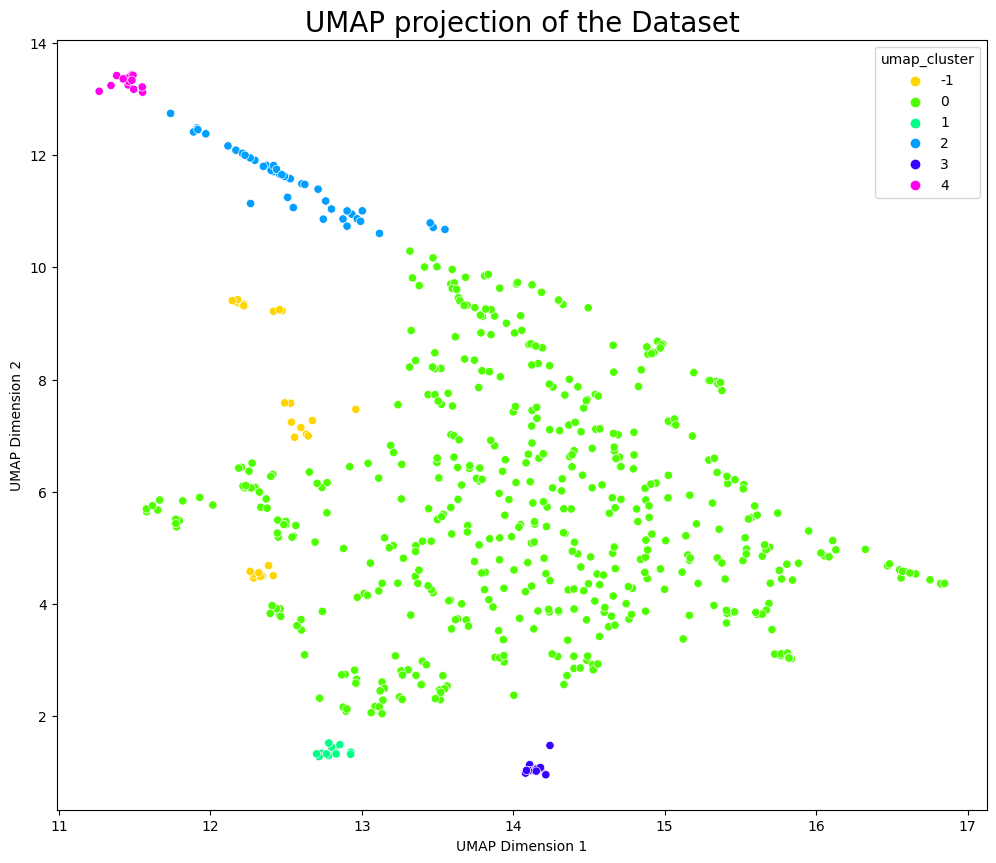

In [9]:
# UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(train_data.drop(['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control'], axis=1))

# Using DBSCAN for clustering UMAP output
clustering = DBSCAN(eps=0.5, min_samples=10).fit(embedding)
train_data['umap_cluster'] = clustering.labels_

# Visualizing UMAP output with clusters
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=embedding[:, 0], 
    y=embedding[:, 1], 
    hue=train_data['umap_cluster'], 
    palette=sns.color_palette("hsv", len(set(clustering.labels_))),
    legend='full'
)
plt.title('UMAP projection of the Dataset', fontsize=20)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


# Prepare data for SHAP analysis
X = train_data.drop(['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control', 'umap_cluster'], axis=1)
y = train_data['umap_cluster']

# Train a model for SHAP analysis
model = RandomForestClassifier(random_state=0, n_estimators=100)
model.fit(X, y)

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X.sample(100))  # Using a sample for speed

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X.iloc[0])

In [10]:
for gene in ['A1BG', 'A1BG-AS1', 'A2M']:  # Replace with genes of interest
    result = stats.kruskal(*[group[gene].values for name, group in train_data.groupby('cell_type')])
    print(f"Kruskal-Wallis test for {gene}: H-statistic={result.statistic}, p-value={result.pvalue}")

Kruskal-Wallis test for A1BG: H-statistic=39.55635317144697, p-value=1.8348199462818108e-07
Kruskal-Wallis test for A1BG-AS1: H-statistic=22.895436287730718, p-value=0.00035346185047222466
Kruskal-Wallis test for A2M: H-statistic=32.361231501548446, p-value=5.0386173921364315e-06


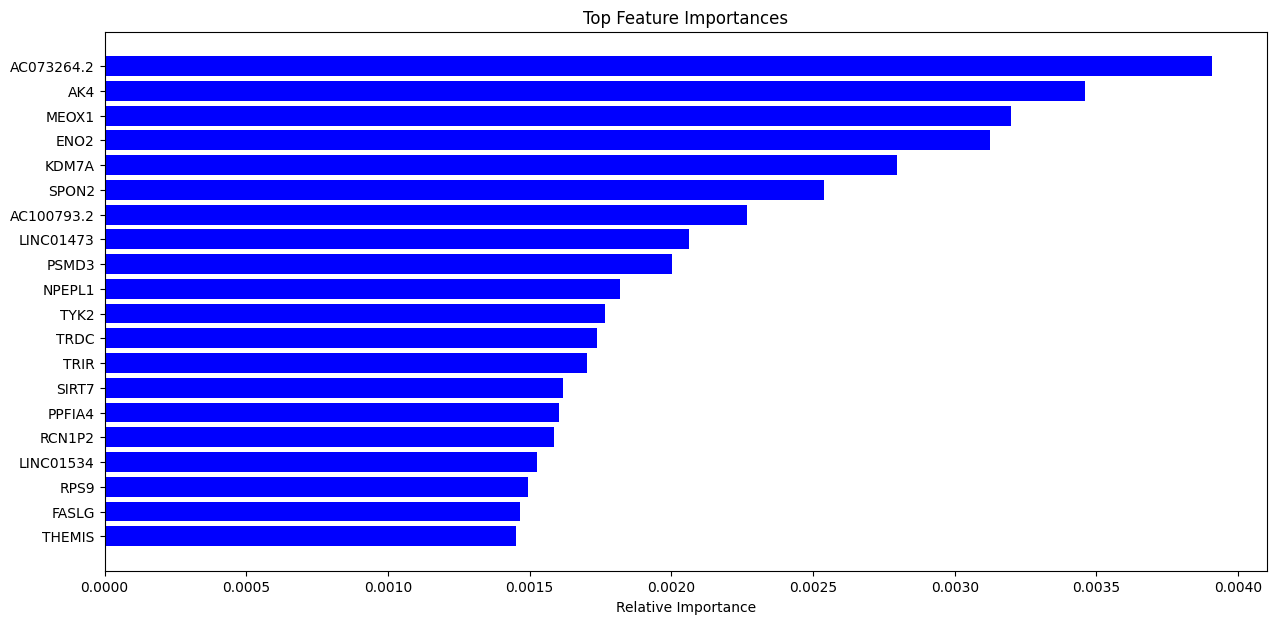

In [11]:
le = LabelEncoder()
train_data['cell_type_encoded'] = le.fit_transform(train_data['cell_type'])

# Define features and target
X = train_data.drop(['cell_type', 'cell_type_encoded', 'sm_name', 'sm_lincs_id', 'SMILES', 'control'], axis=1)
y = train_data['cell_type_encoded']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the RandomForest model on the training data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances from the model
importances = rf.feature_importances_

# Plot the top N feature importances
top_n = 20  # Specify how many top features you'd like to visualize
indices = np.argsort(importances)[-top_n:]
plt.figure(figsize=(15, 7))
plt.title('Top Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

---

In [12]:
# Displaying the shape of the training and ID map datasets
id_map = pd.read_csv(f'{BASE}id_map.csv')

In [13]:
id_map.head()

,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867


In [14]:
display(train_data.head())

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,umap_cluster,cell_type_encoded
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755,0,2
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887,0,3
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365,0,4
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024,0,5
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629,0,2


In [15]:
display(train_data.describe())

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,umap_cluster,cell_type_encoded
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,...,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.366769,0.250951,0.148259,0.155733,0.684275,0.946273,0.000582,0.348203,0.009424,0.062662,...,0.018584,0.267114,0.497043,0.382672,0.240726,0.161087,-0.160735,-0.071255,0.278502,3.330619
std,1.634697,1.188660,2.275410,2.184095,3.189206,3.826391,0.703410,1.259422,0.952243,1.237806,...,1.333236,1.439952,1.691722,1.430553,0.918039,0.779918,0.932961,0.748377,0.916921,1.293656
min,-3.258689,-4.067518,-28.552191,-17.801989,-6.378904,-6.908058,-3.167504,-2.825505,-3.654218,-8.042101,...,-21.273505,-5.520507,-6.780020,-2.617712,-8.310726,-3.456731,-7.189487,-4.819105,-1.000000,0.000000
25%,-0.215161,-0.267728,-0.230129,-0.229460,-0.190989,-0.123963,-0.261792,-0.197019,-0.356774,-0.214164,...,-0.421265,-0.275030,-0.119912,-0.135779,-0.141982,-0.169364,-0.479099,-0.402733,0.000000,2.000000
50%,0.082722,0.102076,0.044717,0.036156,0.116411,0.131515,0.009045,0.144223,-0.028306,0.068134,...,-0.010158,0.065780,0.148876,0.145279,0.137559,0.062804,-0.083260,-0.058601,0.000000,3.000000
75%,0.528015,0.523162,0.405858,0.532216,0.616725,0.580870,0.268029,0.560221,0.253911,0.413308,...,0.361876,0.482989,0.683587,0.600652,0.510566,0.487592,0.266170,0.252387,0.000000,4.000000
max,22.085428,14.421991,27.557166,27.603715,35.278040,34.785942,5.079223,15.589494,10.855080,6.518868,...,10.649018,17.231287,23.721492,23.089832,10.844942,4.822008,7.826692,3.534737,4.000000,5.000000


## Model Training and Evaluation

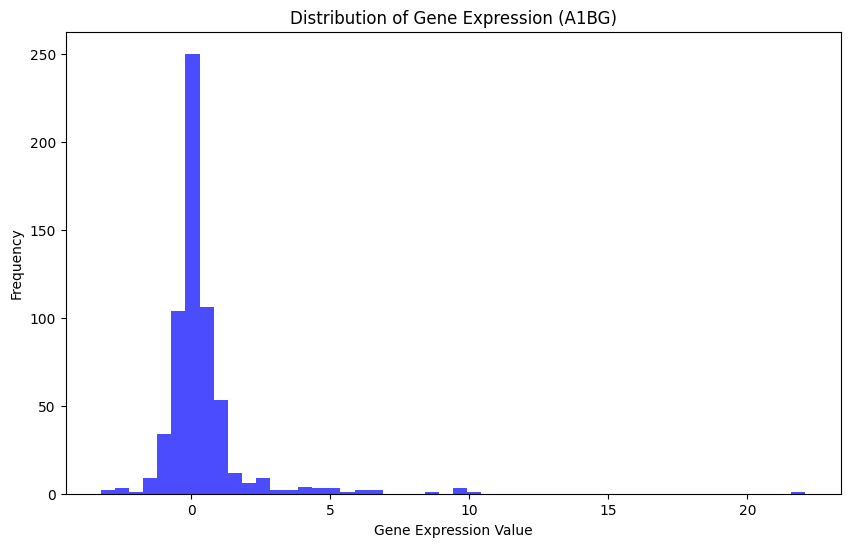

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(train_data['A1BG'], bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Gene Expression (A1BG)")
plt.xlabel("Gene Expression Value")
plt.ylabel("Frequency")
plt.show()

In [17]:
print("Training Data Shape:", train_data.shape)
print("Id Map Data Shape:", id_map.shape)

Training Data Shape: (614, 18218)
Id Map Data Shape: (255, 3)


In [18]:
t0start = time.time()

In [19]:
%%time
fn = '/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet'
df_de_train = pd.read_parquet(fn)# , index_col = 0)
print(df_de_train.shape)
df_de_train

(614, 18216)
CPU times: user 1.92 s, sys: 441 ms, total: 2.36 s
Wall time: 1.3 s


,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [20]:
%%time
fn = '/kaggle/input/open-problems-single-cell-perturbations/id_map.csv'
df_id_map = pd.read_csv(fn)
print(df_id_map.shape)
display(df_id_map)
fn = '/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv'
df = pd.read_csv(fn, index_col = 0)
print(df.shape)
df

(255, 3)


,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867
...,...,...,...
250,250,Myeloid cells,Vandetanib
251,251,Myeloid cells,Vanoxerine
252,252,Myeloid cells,Vardenafil
253,253,Myeloid cells,Vorinostat


(255, 18211)
CPU times: user 4.21 s, sys: 57.8 ms, total: 4.27 s
Wall time: 4.4 s


,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
%%time 
n_components = 35

predict_method = 'train_aggregation_by_compounds_with_denoising_TSVD'

if '_pca' in predict_method:
    str_inf_target_dimred = 'PCA' 
    reducer = PCA(n_components=n_components )
elif '_ICA' in predict_method:
    str_inf_target_dimred = 'ICA' 
    reducer = FastICA(n_components=n_components, random_state=0, whiten='unit-variance')
elif '_TSVD' in predict_method:
    str_inf_target_dimred = 'TSVD' 
    reducer = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
else:
    str_inf_target_dimred = ''
    
print(str_inf_target_dimred, reducer)

TSVD TruncatedSVD(n_components=35, n_iter=7, random_state=42)
CPU times: user 1.64 ms, sys: 1.04 ms, total: 2.67 ms
Wall time: 3.29 ms


In [22]:
Y = df_de_train.iloc[:,5:].values
Yr = reducer.fit_transform(Y)
pd.DataFrame(Yr).corr(method = 'spearman').round(2)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1.00,-0.34,0.21,-0.48,0.27,0.30,0.37,-0.16,-0.12,-0.26,...,-0.09,0.04,-0.06,-0.24,0.17,-0.09,0.06,0.07,0.05,0.10
1,-0.34,1.00,-0.07,0.35,-0.19,0.15,-0.42,0.02,0.10,-0.21,...,0.06,-0.02,-0.02,0.26,-0.04,-0.03,-0.01,0.05,-0.19,0.01
2,0.21,-0.07,1.00,-0.32,0.20,-0.02,0.35,0.31,-0.03,0.23,...,-0.25,-0.07,0.08,-0.44,-0.30,-0.06,-0.14,0.06,0.08,0.19
3,-0.48,0.35,-0.32,1.00,-0.40,0.03,-0.46,0.01,-0.01,-0.18,...,0.03,-0.09,0.09,0.35,-0.10,0.02,0.00,-0.10,-0.03,-0.11
4,0.27,-0.19,0.20,-0.40,1.00,0.24,-0.01,-0.04,-0.19,-0.07,...,-0.18,0.11,-0.18,-0.22,0.06,0.05,-0.17,0.02,0.15,0.08
5,0.30,0.15,-0.02,0.03,0.24,1.00,-0.24,-0.27,-0.08,-0.39,...,-0.08,0.01,-0.11,0.18,0.16,-0.03,-0.10,-0.04,0.14,0.08
6,0.37,-0.42,0.35,-0.46,-0.01,-0.24,1.00,0.09,-0.18,0.03,...,-0.06,-0.06,0.24,-0.38,-0.06,-0.10,0.23,0.02,0.00,0.04
7,-0.16,0.02,0.31,0.01,-0.04,-0.27,0.09,1.00,-0.01,0.20,...,-0.25,-0.24,0.25,-0.27,-0.48,0.08,-0.08,-0.11,0.21,0.09
8,-0.12,0.10,-0.03,-0.01,-0.19,-0.08,-0.18,-0.01,1.00,0.27,...,0.06,-0.14,-0.14,0.02,0.05,-0.04,-0.07,0.00,-0.19,-0.13
9,-0.26,-0.21,0.23,-0.18,-0.07,-0.39,0.03,0.20,0.27,1.00,...,0.08,0.06,-0.03,-0.19,-0.20,0.05,-0.16,-0.04,0.05,0.04


In [23]:
%%time
n_components_for_compound_encoding = 3
quantile = 0.54
df_tmp = pd.DataFrame(Yr[:, :n_components_for_compound_encoding  ], index = df_de_train.index  )
df_tmp['column for aggregation'] = df_de_train['sm_name']
df_compound_encoded = df_tmp.groupby('column for aggregation').quantile( quantile )
print('df_compound_encoded.shape', df_compound_encoded.shape )
display( df_compound_encoded )

X = pd.DataFrame(index = df_de_train['sm_name']) # 
X['IX'] = np.arange(len(df_de_train))
X = X.join( df_compound_encoded , how = 'left').sort_values('IX')
X = X.iloc[:,1:]
X = X.values 
X.shape

df_compound_encoded.shape (146, 3)


,0,1,2
column for aggregation,,,
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine,22.664683,0.209536,-0.544278
ABT-199 (GDC-0199),24.125970,0.187835,0.144659
ABT737,62.872921,-0.093407,0.264872
AMD-070 (hydrochloride),21.136395,3.053320,2.801800
AT 7867,23.538966,6.781847,1.854803
...,...,...,...
Vandetanib,-17.795870,5.256842,0.798427
Vanoxerine,28.534587,5.279237,-2.685573
Vardenafil,-12.045052,1.253801,-1.415164


CPU times: user 15.4 ms, sys: 1.98 ms, total: 17.4 ms
Wall time: 22.3 ms


(614, 3)

In [24]:
enc = OrdinalEncoder()
X = enc.fit_transform(df_de_train[ ['cell_type', 'sm_name']])
X.shape

(614, 2)

In [25]:
%%time
n_components_for_compound_encoding = 20
quantile = 0.54
df_tmp = pd.DataFrame(Yr[:, :n_components_for_compound_encoding  ], index = df_de_train.index  )
df_tmp['column for aggregation'] = df_de_train['sm_name']
df_compound_encoded = df_tmp.groupby('column for aggregation').mean() # quantile( quantile )
print('df_compound_encoded.shape', df_compound_encoded.shape )

X = pd.DataFrame(index = df_de_train['sm_name']) # 
X['IX'] = np.arange(len(df_de_train))
X = X.join( df_compound_encoded , how = 'left').sort_values('IX')
X = X.iloc[:,1:]
X = X.values 
print( X.shape )

X_submit = pd.DataFrame(index = df_id_map['sm_name']) # 
X_submit['IX'] = np.arange(len(X_submit))
X_submit = X_submit.join( df_compound_encoded , how = 'left').sort_values('IX')
X_submit = X_submit.iloc[:,1:]
X_submit = X_submit.values 
print( X_submit.shape )

df_compound_encoded.shape (146, 20)
(614, 20)
(255, 20)
CPU times: user 9.68 ms, sys: 938 µs, total: 10.6 ms
Wall time: 12.9 ms


In [26]:
%%time 
n_splits = 3
kf = KFold(n_splits=n_splits, random_state = 42, shuffle = True )
IX = pd.DataFrame(); IX['IX'] = range(len(df_de_train))

alpha_regularization_for_linear_models = 100000
model = Ridge(alpha=alpha_regularization_for_linear_models)

Y = df_de_train.iloc[:,5:].values

Y_reduced_submit = np.zeros( (len(df_id_map) , Yr.shape[1] )   ); cnt_blend_submit = 0
Y_submit = np.zeros( (len(df_id_map) , 18211 )   ); cnt_blend_submit = 0
Y_oof = np.zeros( (len(df_de_train) , 18211 )   ); cnt_blend_submit = 0

CPU times: user 11.6 ms, sys: 19 ms, total: 30.6 ms
Wall time: 30.5 ms


In [27]:
print(X.shape)
for i, (train_index, test_index) in enumerate(kf.split(IX)):
    print(f"Fold {i}:", len(test_index) )
    
    Yr_train = reducer.fit_transform(Y[train_index,:])
    Yr_test = reducer.transform(Y[test_index,:])
    X_train = X[train_index,:]
    X_test = X[test_index,:]
    model.fit(X_train, Yr_train)
    Yr_pred = model.predict(X_test) # , Yr_train)
    r2 = r2_score(Yr_test,  Yr_pred )
    print('r2 test:', r2)
    r2_test = r2
    Y_oof[test_index,: ] = reducer.inverse_transform(Yr_pred)
    
    Yr_pred = model.predict(X_train) # , Yr_train)
    r2 = r2_score(Yr_train,  Yr_pred )
    print('r2 train', r2)
    Y_reduced_submit =  (Y_reduced_submit * cnt_blend_submit + model.predict(X_submit) ) / ( cnt_blend_submit + 1)
    Y_submit =  (Y_submit * cnt_blend_submit + reducer.inverse_transform(model.predict(X_submit) ) ) / ( cnt_blend_submit + 1)
    cnt_blend_submit += 1
    
s = mean_squared_error(Y,Y_oof, squared = False)
print(s)

(614, 20)
Fold 0: 205
r2 test: 0.09255561893220275
r2 train 0.20151684319105737
Fold 1: 205
r2 test: 0.07677444308698261
r2 train 0.20537036419632987
Fold 2: 204
r2 test: 0.125140327287913
r2 train 0.19156905974539354
1.820363648932503


In [28]:
%%time 
n_splits = 3
kf = KFold(n_splits=n_splits, random_state = 42, shuffle = True )
IX = pd.DataFrame(); IX['IX'] = range(len(df_de_train))

alpha_regularization_for_linear_models = 100000
model = Ridge(alpha=alpha_regularization_for_linear_models)

categorical_features = ['cell_type','sm_name']
model = MultiOutputRegressor( CatBoostRegressor(cat_features=categorical_features, verbose = 0,  # Categorical features ) ) 
                        iterations=300,  # Number of boosting iterations
                          depth=5,        # Depth of the trees
                          learning_rate=0.015,  # Learning rate
                          loss_function='RMSE'))  # Specify your loss function (e.g., RMSE for regression)
#                           verbose=0) ) # Set verbose to 0 to suppress output


Y = df_de_train.iloc[:,5:].values

CPU times: user 13.7 ms, sys: 18 ms, total: 31.7 ms
Wall time: 33.4 ms


In [29]:
Y_reduced_submit = np.zeros( (len(df_id_map) , Yr.shape[1] )   ); cnt_blend_submit = 0
Y_submit = np.zeros( (len(df_id_map) , 18211 )   ); cnt_blend_submit = 0
Y_oof = np.zeros( (len(df_de_train) , 18211 )   ); cnt_blend_submit = 0

df_train = df_de_train[['cell_type','sm_name']]

X_submit = df_id_map[ ['cell_type','sm_name'] ]

In [30]:
print(X.shape)
for i, (train_index, test_index) in enumerate(kf.split(IX)):
    print(f"Fold {i}:", len(test_index) )
    
    Yr_train = reducer.fit_transform(Y[train_index,:])
    Yr_test = reducer.transform(Y[test_index,:])
    X_train = df_de_train[categorical_features].iloc[train_index,:]
    X_test = df_de_train[categorical_features].iloc[test_index,:]
    
    model.fit(X_train, Yr_train)
    Yr_pred = model.predict(X_test) # , Yr_train)
    r2 = r2_score(Yr_test,  Yr_pred )
    print('r2 test:', r2)
    r2_test = r2
    Y_oof[test_index,: ] = reducer.inverse_transform(Yr_pred)
    
    Yr_pred = model.predict(X_train) # , Yr_train)
    r2 = r2_score(Yr_train,  Yr_pred )
    print('r2 train', r2)
    Y_reduced_submit =  (Y_reduced_submit * cnt_blend_submit + model.predict(X_submit) ) / ( cnt_blend_submit + 1)
    Y_submit =  (Y_submit * cnt_blend_submit + reducer.inverse_transform(model.predict(X_submit) ) ) / ( cnt_blend_submit + 1)
    cnt_blend_submit += 1
    

s = mean_squared_error(Y,Y_oof, squared = False)
print(s)

(614, 20)
Fold 0: 205
r2 test: 0.04206515747526665
r2 train 0.176139889307586
Fold 1: 205
r2 test: 0.0419053215224501
r2 train 0.188050539604398
Fold 2: 204
r2 test: 0.09858820288780185
r2 train 0.1732176070686227
1.9626060883886094


## Submission Preparation

In [31]:
df_submit = pd.DataFrame(Y_submit, columns = df_de_train.columns[5:])
df_submit.index.name = 'id'
print( df_submit.shape )
display(df_submit)
df_submit.to_csv('submission.csv')

(255, 18211)


,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
id,,,,,,,,,,,,,,,,,,,,,
0,2.025858,0.707148,1.563985,2.330323,7.260251,5.073104,0.118226,1.041383,0.345913,1.044700,...,-0.013655,0.846732,0.441837,1.452402,1.972319,1.098377,0.809565,0.360722,-0.119688,0.229690
1,1.463149,0.558300,1.178327,1.709475,5.884395,3.614504,0.239940,0.724625,0.532726,0.478105,...,0.080576,0.682147,0.078436,1.010324,1.396517,0.761090,0.394645,0.076115,-0.110279,0.186715
2,2.132604,1.127584,0.157222,1.481848,5.634916,5.119347,0.316527,1.053388,0.503305,0.481355,...,0.366844,0.898648,0.105716,1.496485,1.943256,1.261087,0.443378,0.194560,-0.039864,-0.025436
3,1.571889,0.794700,0.227554,1.322667,4.292387,3.818451,0.141399,0.720132,0.409354,0.709666,...,0.319660,0.649103,-0.270926,1.172192,1.212285,0.657473,0.254508,0.370356,0.237785,0.082808
4,1.691632,0.525942,1.528849,2.157864,6.625141,4.284565,0.067704,0.997747,0.411075,0.976312,...,-0.086113,0.719466,0.153132,1.208848,1.772138,0.854219,0.682207,0.335744,-0.129290,0.173192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,1.150077,0.422291,-1.482613,0.837483,5.404197,2.764436,0.258785,0.149752,0.439291,0.379081,...,0.143373,0.049369,-1.269987,0.040268,1.160241,0.302118,-0.452473,-0.368284,-0.146954,-0.143241
251,2.174331,0.979952,-1.062539,1.620386,8.031937,5.144562,0.270570,0.713079,0.156404,0.444333,...,0.242413,0.512597,-0.971904,0.661817,2.390912,1.183989,-0.025314,-0.057110,-0.137062,0.020874
252,0.581294,0.336256,-2.920023,0.168994,4.037425,1.974841,0.150440,-0.421646,0.033753,0.602981,...,0.130175,-0.166918,-2.011394,-0.144690,0.622583,-0.111903,-0.843828,-0.385191,0.218591,-0.151546
